# autoMI with Pink Noise
This notebook brings you through a PSD, autocorrelation, and AutoMI with synthetic pink noise. Finally, we give an example of power-law model fitting on the data. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import mlab
import matplotlib.pyplot as plt
import numpy as np
import colorednoise as cn

### Use the colorednoise package to generate pink noise
- source: "On genrating power law noise", Timmer and Konig, (1995) Astron. Astrophys.

In [3]:
beta = 0.5 # the exponent
samples = 2**20 # number of samples to generate
y = cn.powerlaw_psd_gaussian(beta, samples)

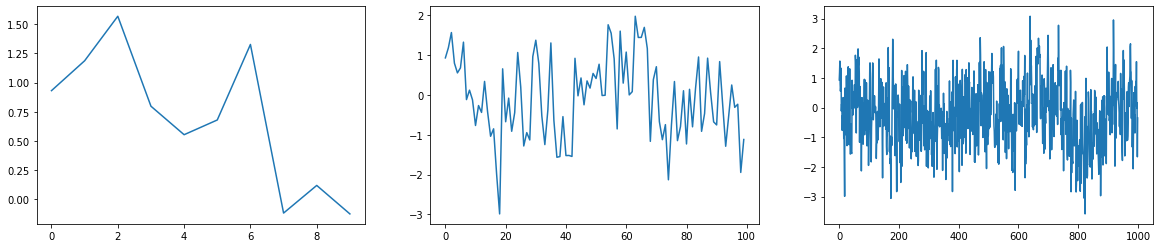

In [4]:
fig, axs = plt.subplots(ncols = 3, figsize=(20,4))
axs[0].plot(y[:10])
axs[1].plot(y[:100])
axs[2].plot(y[:1000])

### Power spectral density

Text(0, 0.5, 'Power')

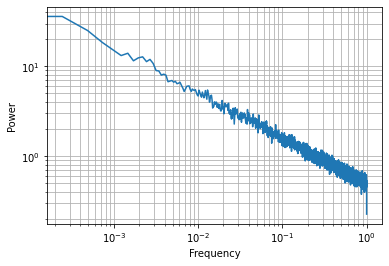

In [5]:
fig, ax = plt.subplots()
s, f = mlab.psd(y, NFFT=2**13)
ax.loglog(f,s)
ax.grid(which='both')
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')

### Auto correlation

In [6]:
from tqdm.auto import tqdm
def autocorrelate(y, range_ = range(1,100)):
    return [np.corrcoef(y[i:], y[:-i])[0][1] for i in tqdm(range_)]

In [7]:
range_ = np.arange(1,1000)

In [8]:
# compute autocorrelation over the range of lags
autocorr = autocorrelate(y, range_)

  0%|          | 0/999 [00:00<?, ?it/s]

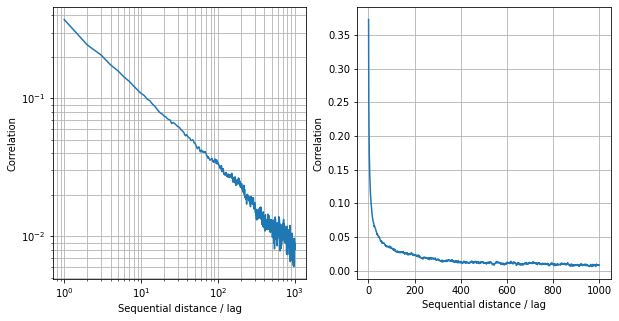

In [9]:
# plot the autocorrelation in log-log and linear
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(range_, autocorr)
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('Correlation')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(which='both')

ax = axs[1]
ax.plot(range_, autocorr)
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('Correlation')
ax.grid(which='both')

### Auto mutual information
- We first need discrete states as input to the sequential mutual information function. To that end, we can bin our signal across 10 discrete states.
- We can then compute the Auto Mutual Information (AutoMI). The output of the AutoMI function will give us both the MI of the true signal and the MI of the shuffled signal. 
- Currently the Grassberger method of entropy estimation supports an estimate of the variance of the entropy and the naiive entropy estimation does not. 

In [10]:
# digitize signal into discrete states
nbins = 10 # how many bins to compute over
bins =  np.linspace(np.min(y), np.max(y), nbins)
y_dig = np.digitize(y, bins, right=True)

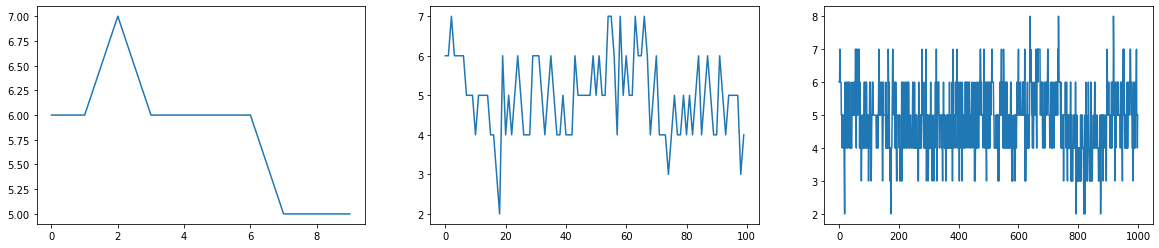

In [11]:
fig, axs = plt.subplots(ncols = 3, figsize=(20,4))
axs[0].plot(y_dig[:10])
axs[1].plot(y_dig[:100])
axs[2].plot(y_dig[:1000])

In [12]:
from automi import sequential_mutual_information as smi

In [13]:
(MI, _), (shuff_MI, _) = smi(
    [y_dig], distances=range_
)

  0%|          | 0/999 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 999 out of 999 | elapsed:   42.2s finished


  0%|          | 0/999 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 999 out of 999 | elapsed:   44.2s finished


### Plotting the AutoMI
- If we plot the raw AutoMI it decays towards chance. 

Text(0, 0.5, 'MI')

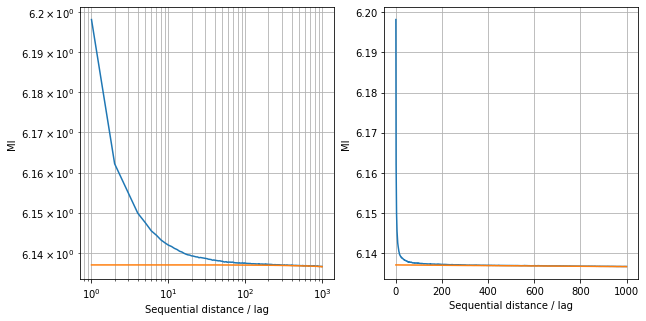

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(range_, MI)
ax.plot(range_, shuff_MI)
ax.grid(which='both')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')

ax = axs[1]
ax.plot(range_, MI)
ax.plot(range_, shuff_MI)
ax.grid(which='both')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')

### Plotting the AutoMI relative to chance
- If we plot the AutoMI relative to chance, we oberserve a power-law. 

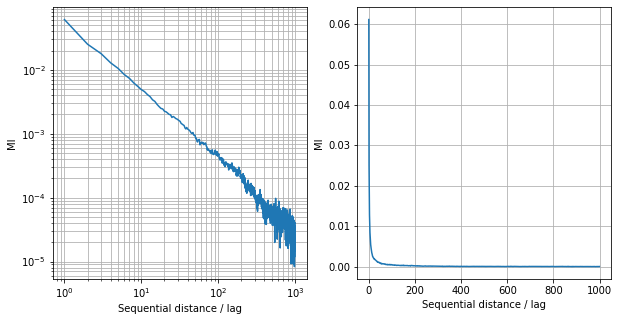

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(range_, MI - shuff_MI)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('MI')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')
ax.grid(which='both')

ax = axs[1]
ax.plot(range_, MI - shuff_MI)
ax.set_xlabel('MI')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')
ax.grid(which='both')


### Fitting a decay model

In [16]:
from automi import fit_model

In [17]:
decay_model, model_y = fit_model(
    distances = range_,
    sig = MI - shuff_MI,
)
decay_model

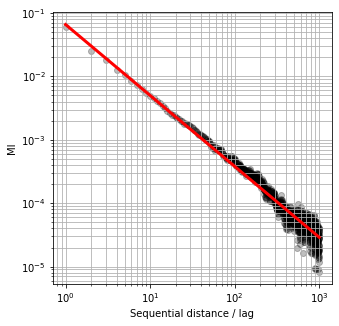

In [18]:
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
ax.scatter(range_, MI - shuff_MI, color = 'k', alpha = 0.25)

ax.plot(range_, model_y, lw=3, color = 'red')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')
ax.grid(which='both')